In [5]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.io as sio
from time import time
import pickle as pkl
import multiprocessing
import sys
from datetime import datetime,timedelta

def get_min_data(date_str):
    min_data = pd.read_feather(r'/home/datamake8/data0/min_data' + '//' + date_str + '.fea')
    min_data['StockID'] = min_data['StockID'].apply(lambda x:x[2:]).astype(str)
    min_data['time'] = min_data['time'].astype(int)
    #需要转换time的格式，与因子的对齐
    min_data['time'] = min_data['time'].apply(lambda x:x-40-1 if x%100==0 else x-1)
    amt_data = min_data[['time','StockID','amount']].pivot_table(index='time',columns='StockID',values='amount').sort_index(axis=0).sort_index(axis=1)
    vol_data = min_data[['time','StockID','vol']].pivot_table(index='time',columns='StockID',values='vol').sort_index(axis=0).sort_index(axis=1)
    vwap_data = amt_data.loc[930:1000].sum(axis=0) / (vol_data.loc[930:1000].sum(axis=0)+1e-7)
    return vwap_data

def divid_earn_seq(date_list, hold_df_dict, trade_df_dict):
    close_price = pd.read_pickle('/home/datamake8/data0/ohlc_fea/CLOSE_PRICE.pkl').replace(0,np.nan).ffill()
    close_price.index = pd.to_datetime(close_price.index).strftime('%Y%m%d')
    daily_amount = pd.read_pickle('/home/datamake8/data0/ohlc_fea/TURNOVER_VALUE.pkl').fillna(0)
    daily_amount.index = pd.to_datetime(daily_amount.index).strftime('%Y%m%d')
    open_price = pd.read_pickle('/home/datamake8/data0/ohlc_fea/OPEN_PRICE.pkl').replace(0,np.nan).ffill().shift(-1)
    open_price.index = pd.to_datetime(open_price.index).strftime('%Y%m%d')

    total_ret_se = {}
    ls_ret_se = {}
    t0_ret_se = {}
    open_ret_se = {}
    for date in tqdm(date_list):
        open_df, close_df = hold_df_dict[date]
        vwap_data = close_price.loc[date.strftime('%Y%m%d')].reindex(close_df.index)
        # vwap_data = get_min_data(date.strftime('%Y%m%d')).reindex(close_df.index)
        open_cash, open_lock_cash = open_df['cash'].iloc[0], open_df['lock_cash'].iloc[0]
        close_cash, close_lock_cash = close_df['cash'].iloc[0], close_df['lock_cash'].iloc[0]
        #使用收盘价模拟交易，看多空持仓的收益是多少
        open_value = open_df['hold_amt'].sum() + open_df['debt_amt'].sum() + open_cash + open_lock_cash - open_df['rq_amt'].sum()
        hold_vol_diff = close_df['hold_vol'] - open_df['hold_vol']
        rq_vol_diff = (close_df['rq_vol'] - close_df['debt_vol']) - (open_df['rq_vol'] - open_df['debt_vol'])
        now_cash = open_cash
        for code in hold_vol_diff.index:
            vol = hold_vol_diff[code]
            if vol==0: continue
            now_cash -= vol * vwap_data[code] * {0:0.9992,1:1}[int(vol>=0)]
        now_lock_cash = open_lock_cash
        for code in rq_vol_diff.index:
            vol = rq_vol_diff[code]
            if vol==0: continue
            now_lock_cash += vol * vwap_data[code] * {1:0.9992,0:1}[int(vol>=0)]
        
        ls_earn = close_df['hold_amt'].sum() + close_df['debt_amt'].sum() + now_cash + now_lock_cash - close_df['rq_amt'].sum()
        close_value = close_df['hold_amt'].sum() + close_df['debt_amt'].sum() + close_cash + close_lock_cash - close_df['rq_amt'].sum()
        total_ret = (close_value - open_value) / open_value
        ls_ret = (ls_earn - open_value) / open_value
        t0_ret = total_ret - ls_ret
        total_ret_se[date] = total_ret
        ls_ret_se[date] = ls_ret
        t0_ret_se[date] = t0_ret
        #用第二天开盘价计算收益
        pre_open_price = open_price.loc[open_price.index.tolist()[open_price.index.tolist().index(date.strftime('%Y%m%d'))-1]].reindex(open_df.index)
        today_open_price = open_price.loc[date.strftime('%Y%m%d')].reindex(close_df.index)
        pre_open_value = open_df['hold_vol'] @ pre_open_price + open_df['debt_vol'] @ pre_open_price + open_cash + open_lock_cash - open_df['rq_vol'] @ pre_open_price
        next_open_value = close_df['hold_vol'] @ today_open_price + close_df['debt_vol'] @ today_open_price + now_cash + now_lock_cash - close_df['rq_vol'] @ today_open_price
        next_open_ret = (next_open_value - pre_open_value) / pre_open_value
        open_ret_se[date] = next_open_ret
    
    #统计每日成交量占比
    trade_ratio_dict = {}
    for date in tqdm(date_list):
        trade_df = trade_df_dict[date]
        trade_df['amt'] = trade_df['amt'].abs()
        trade_df = trade_df.groupby('code')['amt'].sum()
        trade_df = trade_df / daily_amount.loc[date.strftime('%Y%m%d')].reindex(trade_df.index)
        trade_ratio_dict[date] = trade_df.describe()
    
    return pd.DataFrame([total_ret_se,ls_ret_se,t0_ret_se,open_ret_se],index=['total','ls','t0','openret']).T, pd.DataFrame(trade_ratio_dict)

def analyse(date_list,ret,trade_df_dict,hold_df_dict,initial_money,plotting=False):
    # date_list = list(trade_df_dict.keys())
    divid_ret_df,trade_ratio_df = divid_earn_seq(date_list, hold_df_dict, trade_df_dict)
    print(trade_ratio_df)
    ###
    ret = ret + 0.0001
    nv = (ret+1).cumprod()
    nv_ls = (divid_ret_df['ls']+1).cumprod()
    nv_t0 = (divid_ret_df['t0']+1).cumprod()
    # nv_open = (divid_ret_df['openret']+1).cumprod()
    mean_ret = ret.mean() * 250
    mean_std = ret.std() * np.sqrt(250)
    sharp_ratio = mean_ret / mean_std
    dd_s = nv.cummax() - nv
    mean_dd = dd_s.mean()
    max_dd = dd_s.max()
    dd_date = dd_s.sort_values(ascending=False).index[0]

    # winrate_dict = {}
    # use_dict = {}
    # for date in ret.index:
    #     trade_df_raw = trade_df_dict[date]
    #     trade_df_raw['amt'] = trade_df_raw['volume'] * trade_df_raw['price']
    #     trade_df = -trade_df_raw.groupby('code')['amt'].sum()
    #     winrate_df = (trade_df > 0).astype(int)
    #     winrate = winrate_df.sum() / winrate_df.count()
    #     winrate_dict[date] = winrate
    #     use_ratio = trade_df_raw['amt'].abs().sum() / 2 / initial_money
    #     use_dict[date] = use_ratio
    # winrate = pd.Series(winrate_dict)
    # use_ratio = pd.Series(use_dict)
    
    if plotting is True:
        print('------绝对收益------')
        print('年化收益:' + str(mean_ret))
        print('多空收益:' + str(divid_ret_df['ls'].mean() * 250))
        print('t0收益:' + str(divid_ret_df['t0'].mean() * 250))
        # print('open收益:' + str(divid_ret_df['openret'].mean() * 250))
        print('年化波动:' + str(mean_std))
        print('夏普比率:' + str(sharp_ratio))
        print('平均回撤:' + str(mean_dd))
        print('最大回撤:' + str(max_dd))
        print('回撤日期:' + str(dd_date))
        # print('平均胜率:' + str(winrate.mean()))
        # print('平均底仓使用率:' + str(use_ratio.mean()))
        
        fig, ax1 = plt.subplots(figsize=(15, 7.5))
        ax1.plot(nv, label='strategy')
        ax1.plot(nv_ls, label='long_short')
        ax1.plot(nv_t0, label='t0')
        # ax1.plot(nv_open, label='open')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Net Value')
        ax1.legend()
        ax2 = ax1.twinx()
        ax2.bar(dd_s.index, dd_s, color='red', alpha=0.5)
        ax2.set_ylabel('Max Drawdown')
        plt.title('NV and Max Drawdown')
        plt.show()
        # winrate.plot(figsize=(15, 3),color='red')
        # #在50%胜率线上画一条横线虚线，颜色为蓝色
        # plt.axhline(0.5, color='b', linestyle='--')
        # plt.show()
        # #用红线标注平均胜率

    info_s = pd.Series([mean_ret, mean_std, sharp_ratio, mean_dd, max_dd, dd_date],
                       index=['年化收益', '年化波动', '夏普比率', '平均回撤', '最大回撤', '回撤日期'])
    return info_s

In [32]:
with open(r'/home/datamake8/data0/t0_backtest/T0多空策略0.610168.pkl','rb') as f:
    ans_dict = pkl.load(f)
hold_df_dict = ans_dict['hold_df_dict']
trade_df_dict = ans_dict['trade_df_dict']
tot_account_dict = ans_dict['tot_account_dict']
para = ans_dict['params']
ret_dict = ans_dict['ret_dict']
para

{'im': 100000000,
 'min': 0,
 'rank1': 2.5,
 'rank2': 3.5,
 'back': 2,
 'amp_ratio': 0.5,
 'score_ratio_1m': 0.2,
 'score_ratio_5m': 0.6}

100%|██████████████████████████████████████████████████████████████| 314/314 [00:01<00:00, 301.46it/s]


       2023-01-11  2023-01-12  2023-01-13  2023-01-16  2023-01-17  2023-01-18  \
count   75.000000  109.000000  114.000000  119.000000  116.000000  114.000000   
mean     0.010231    0.012144    0.011724    0.009033    0.010169    0.011350   
std      0.011604    0.015551    0.017219    0.015124    0.012740    0.015293   
min      0.000558    0.000016    0.000013    0.000015    0.000002    0.000463   
25%      0.003306    0.003400    0.002690    0.002496    0.001866    0.003278   
50%      0.005711    0.006794    0.005436    0.004162    0.005887    0.007846   
75%      0.012815    0.014264    0.014183    0.010138    0.011256    0.012640   
max      0.066739    0.096714    0.124249    0.123113    0.060444    0.118541   

       2023-01-19  2023-01-20  2023-01-30  2023-01-31  ...  2024-04-17  \
count  124.000000  117.000000  115.000000  115.000000  ...  114.000000   
mean     0.008861    0.008815    0.005914    0.007036  ...    0.008580   
std      0.010277    0.009961    0.007200    0.0

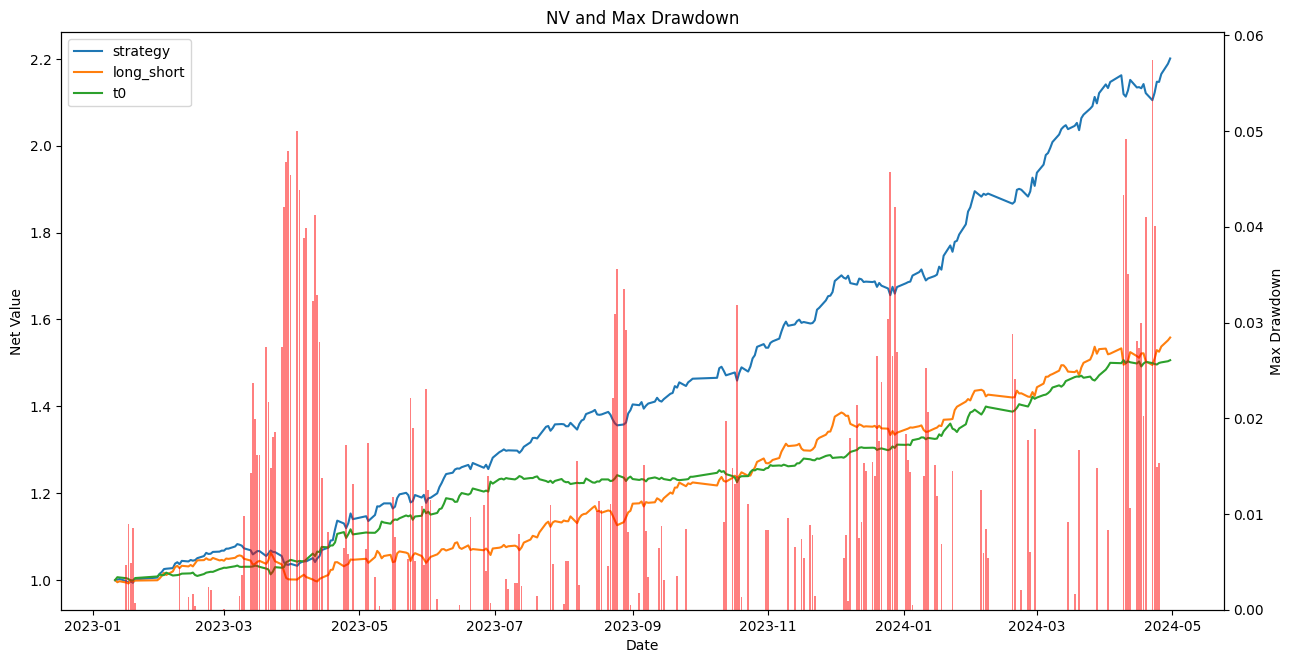

年化收益      0.635168
年化波动      0.110925
夏普比率      5.726081
平均回撤      0.008474
最大回撤      0.057461
回撤日期    2024-04-22
dtype: object

In [33]:
#海通券池结果
# ret_dict = ans_dict['ret_dict']
# ret_dict2 = 
ret1 = pd.Series(ret_dict)
ret1 = ret1[:]
date_list = ret1.index.tolist()
# ret2 = pd.Series(ret_dict2)
# ret1 = pd.concat([ret2,ret1]).sort_index()
analyse(date_list,ret1,trade_df_dict,hold_df_dict,para['im'],plotting=True)

100%|██████████████████████████████████████████████████████████████| 314/314 [00:01<00:00, 294.83it/s]


       2023-01-11  2023-01-12  2023-01-13  2023-01-16  2023-01-17  2023-01-18  \
count  112.000000  147.000000  149.000000  138.000000  147.000000  140.000000   
mean     0.006708    0.003123    0.002862    0.003229    0.003595    0.003533   
std      0.006708    0.003315    0.003329    0.004131    0.003619    0.003697   
min      0.000158    0.000003    0.000002    0.000003    0.000001    0.000002   
25%      0.002073    0.000765    0.000664    0.000749    0.000962    0.001093   
50%      0.004711    0.002203    0.001978    0.002061    0.002235    0.002380   
75%      0.008475    0.004167    0.003629    0.004092    0.005447    0.004637   
max      0.033122    0.018437    0.019746    0.023738    0.016033    0.020368   

       2023-01-19    2023-01-20  2023-01-30  2023-01-31  ...    2024-04-17  \
count  131.000000  1.380000e+02  136.000000  132.000000  ...  1.280000e+02   
mean     0.003804  4.159369e-03    0.003061    0.002839  ...  3.381687e-03   
std      0.003776  3.939999e-03    0

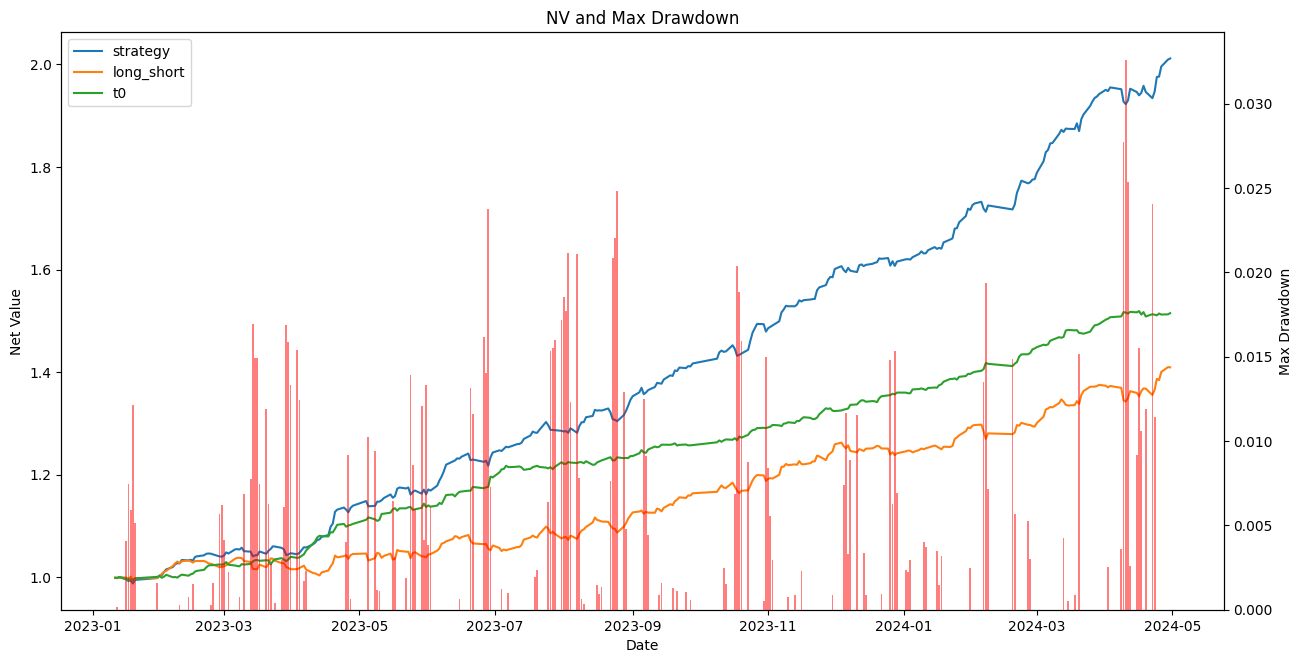

年化收益      0.560218
年化波动      0.080394
夏普比率      6.968399
平均回撤      0.003951
最大回撤      0.032602
回撤日期    2024-04-10
dtype: object

In [7]:
#海通券池结果
# ret_dict = ans_dict['ret_dict']
# ret_dict2 = 
ret1 = pd.Series(ret_dict)
date_list = ret1.index.tolist()
# ret1 = ret1[datetime.strptime('20230701','%Y%m%d').date():]
# ret2 = pd.Series(ret_dict2)
# ret1 = pd.concat([ret2,ret1]).sort_index()
analyse(date_list,ret1,trade_df_dict,hold_df_dict,para['im'],plotting=True)

100%|██████████████████████████████████████████████████████████████| 314/314 [00:01<00:00, 163.54it/s]


       2023-01-11  2023-01-12  2023-01-13  2023-01-16  2023-01-17  2023-01-18  \
count  112.000000  147.000000  149.000000  139.000000  147.000000  140.000000   
mean     0.006709    0.003122    0.002867    0.003206    0.003591    0.003528   
std      0.006713    0.003315    0.003331    0.004128    0.003618    0.003700   
min      0.000158    0.000003    0.000002    0.000003    0.000001    0.000002   
25%      0.002073    0.000765    0.000664    0.000739    0.000962    0.001072   
50%      0.004710    0.002203    0.001978    0.002059    0.002206    0.002361   
75%      0.008475    0.004167    0.003629    0.004069    0.005443    0.004685   
max      0.033122    0.018437    0.019746    0.023738    0.016033    0.020368   

       2023-01-19    2023-01-20  2023-01-30  2023-01-31  ...    2024-04-17  \
count  131.000000  1.380000e+02  136.000000  132.000000  ...  1.280000e+02   
mean     0.003799  4.160439e-03    0.003064    0.002832  ...  3.381687e-03   
std      0.003780  3.936195e-03    0

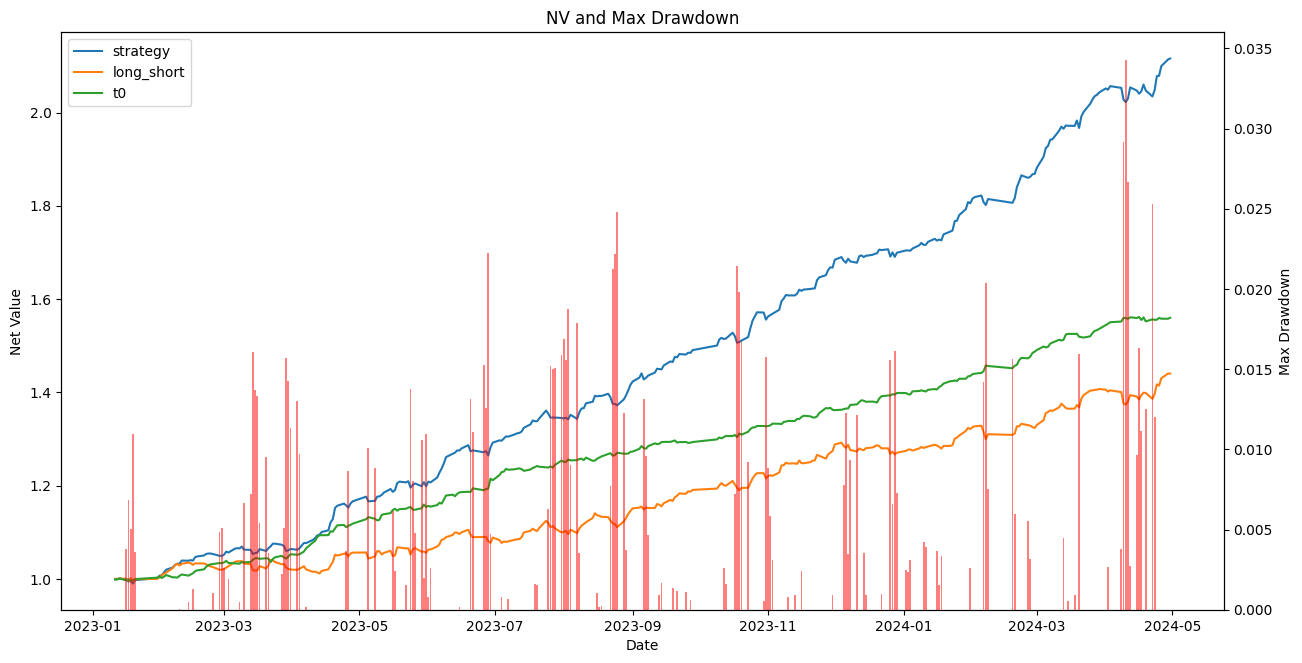

年化收益      0.600633
年化波动       0.08026
夏普比率      7.483552
平均回撤      0.003732
最大回撤      0.034296
回撤日期    2024-04-10
dtype: object

In [211]:
#海通券池结果
# ret_dict = ans_dict['ret_dict']
# ret_dict2 = 
ret1 = pd.Series(ret_dict)
date_list = ret1.index.tolist()
# ret1 = ret1[datetime.strptime('20230701','%Y%m%d').date():]
# ret2 = pd.Series(ret_dict2)
# ret1 = pd.concat([ret2,ret1]).sort_index()
analyse(date_list,ret1,trade_df_dict,hold_df_dict,para['im'],plotting=True)

In [ ]:
#海通券池结果
# ret_dict = ans_dict['ret_dict']
# ret_dict2 = 
ret1 = pd.Series(ret_dict)
date_list = ret1.index.tolist()
# ret1 = ret1[datetime.strptime('20230701','%Y%m%d').date():]
# ret2 = pd.Series(ret_dict2)
# ret1 = pd.concat([ret2,ret1]).sort_index()
analyse(date_list,ret1,trade_df_dict,hold_df_dict,para['im'],plotting=True)

100%|██████████████████████████████████████████████████████████████| 314/314 [00:01<00:00, 289.81it/s]


       2023-01-11  2023-01-12  2023-01-13  2023-01-16  2023-01-17  2023-01-18  \
count  112.000000  147.000000  149.000000  139.000000  147.000000  140.000000   
mean     0.006709    0.003122    0.002867    0.003206    0.003591    0.003528   
std      0.006713    0.003315    0.003331    0.004128    0.003618    0.003700   
min      0.000158    0.000003    0.000002    0.000003    0.000001    0.000002   
25%      0.002073    0.000765    0.000664    0.000739    0.000962    0.001072   
50%      0.004710    0.002203    0.001978    0.002059    0.002206    0.002361   
75%      0.008475    0.004167    0.003629    0.004069    0.005443    0.004685   
max      0.033122    0.018437    0.019746    0.023738    0.016033    0.020368   

       2023-01-19    2023-01-20  2023-01-30  2023-01-31  ...    2024-04-17  \
count  131.000000  1.380000e+02  136.000000  132.000000  ...  1.280000e+02   
mean     0.003799  4.160439e-03    0.003064    0.002832  ...  3.381687e-03   
std      0.003780  3.936195e-03    0

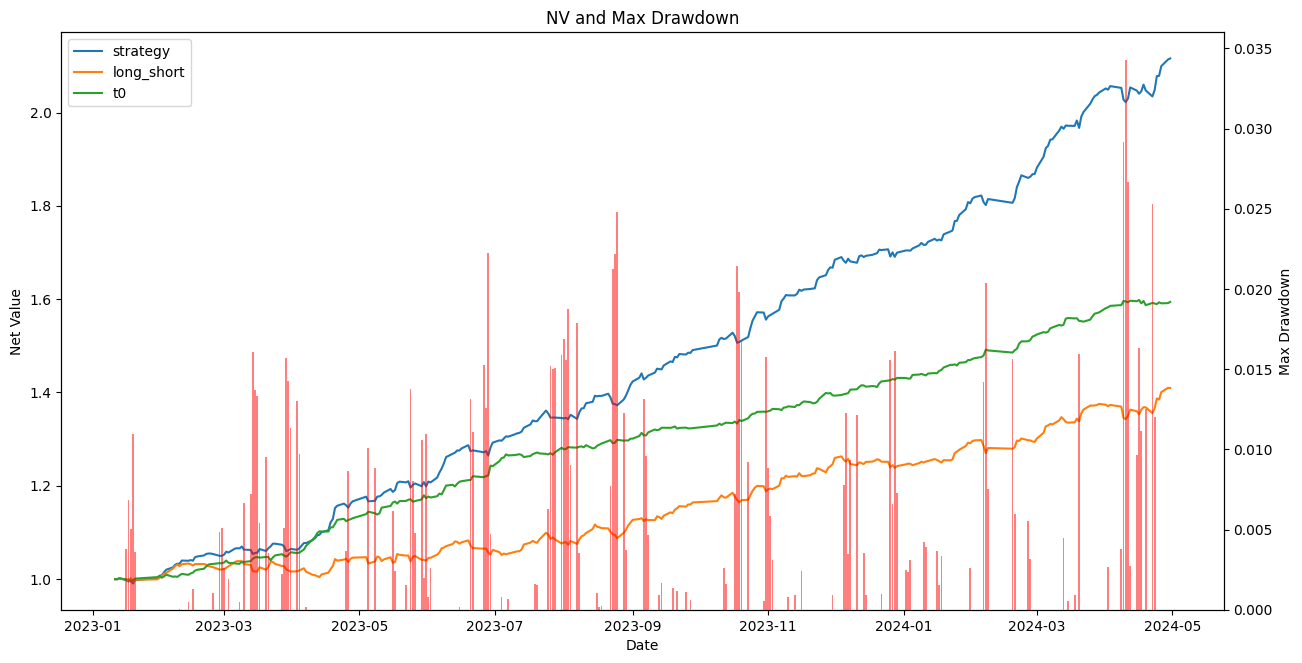

年化收益      0.600633
年化波动       0.08026
夏普比率      7.483552
平均回撤      0.003732
最大回撤      0.034296
回撤日期    2024-04-10
dtype: object

In [205]:
#海通券池结果
# ret_dict = ans_dict['ret_dict']
# ret_dict2 = 
ret1 = pd.Series(ret_dict)
date_list = ret1.index.tolist()
# ret1 = ret1[datetime.strptime('20230701','%Y%m%d').date():]
# ret2 = pd.Series(ret_dict2)
# ret1 = pd.concat([ret2,ret1]).sort_index()
analyse(date_list,ret1,trade_df_dict,hold_df_dict,para['im'],plotting=True)

In [195]:
with open(r'/home/datamake8/data0/t0_backtest/T0多空策略0.568361.pkl','rb') as f:
    ans_dict = pkl.load(f)
hold_df_dict = ans_dict['hold_df_dict']
trade_df_dict = ans_dict['trade_df_dict']
tot_account_dict = ans_dict['tot_account_dict']
para = ans_dict['params']
ret_dict = ans_dict['ret_dict']
date_list = list(tot_account_dict.keys())
date_list = [x for x in date_list if x <= datetime.strptime('20231231','%Y%m%d').date()]
trade_df_dict = {x:trade_df_dict[x] for x in date_list}
hold_df_dict = {x:hold_df_dict[x] for x in date_list}

In [53]:
with open(r'/home/datamake8/data0/t0_backtest/T0多空策略0.538505.pkl','rb') as f:
    ans_dict = pkl.load(f)
hold_df_dict2 = ans_dict['hold_df_dict']
trade_df_dict2 = ans_dict['trade_df_dict']
tot_account_dict2 = ans_dict['tot_account_dict']
para = ans_dict['params']
ret_dict2 = ans_dict['ret_dict']
date_list = list(tot_account_dict2.keys())
date_list = [x for x in date_list if x > datetime.strptime('20231231','%Y%m%d').date()]
trade_df_dict2 = {x:trade_df_dict2[x] for x in date_list}
hold_df_dict2 = {x:hold_df_dict2[x] for x in date_list}
trade_df_dict.update(trade_df_dict2)
hold_df_dict.update(hold_df_dict2)
ret_dict.update(ret_dict2)

100%|███████████████████████████████████████████████████████████████| 290/290 [00:14<00:00, 19.59it/s]


------绝对收益------
年化收益:0.61747019853567
多空收益:0.47080958915860976
t0收益:0.19171625757242716
年化波动:0.07918262660685117
夏普比率:7.798051479164297
平均回撤:0.003770664558916547
最大回撤:0.033798126661432004
回撤日期:2023-04-04


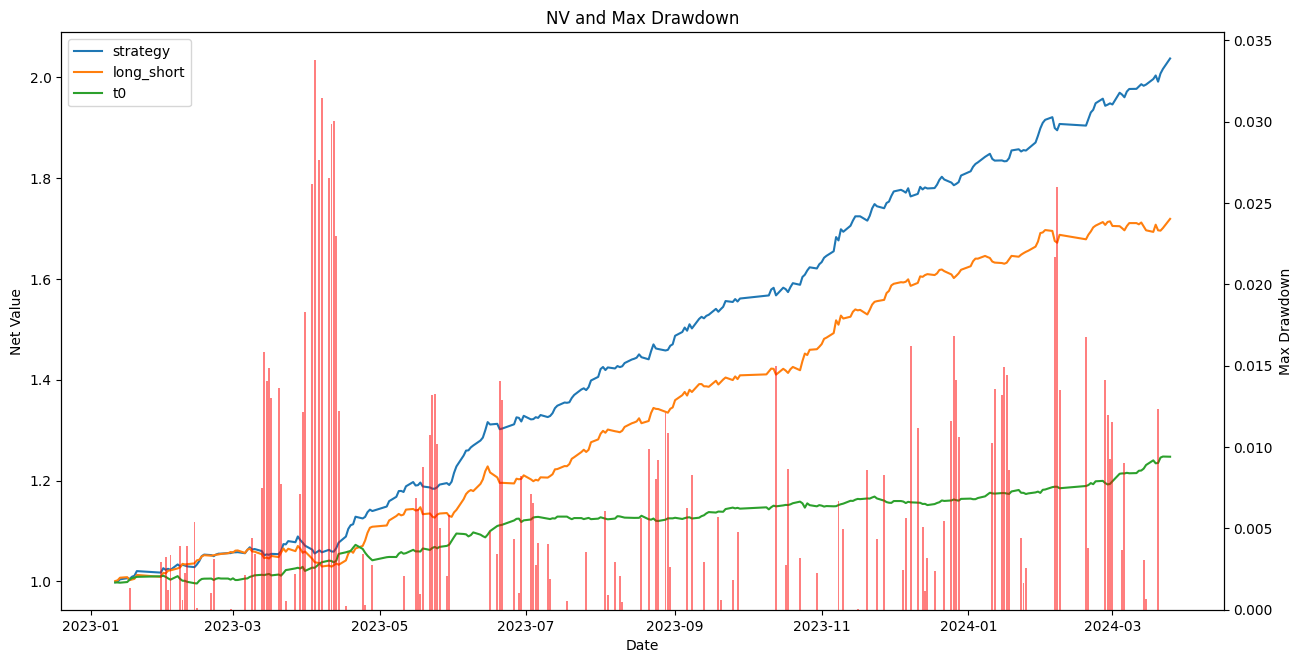

年化收益       0.61747
年化波动      0.079183
夏普比率      7.798051
平均回撤      0.003771
最大回撤      0.033798
回撤日期    2023-04-04
dtype: object

In [54]:
#海通券池结果
# ret_dict = ans_dict['ret_dict']
# ret_dict2 = 
ret1 = pd.Series(ret_dict)
# ret1 = ret1[datetime.strptime('20230701','%Y%m%d').date():]
# ret2 = pd.Series(ret_dict2)
# ret1 = pd.concat([ret2,ret1]).sort_index()
analyse(ret1,trade_df_dict,hold_df_dict,para['im'],plotting=True)

In [64]:
with open(r'/home/datamake8/data0/t0_backtest/T0_lz_分股票回归0.026859.pkl','rb') as f:
    ans_dict = pkl.load(f)
trade_df_dict = ans_dict['trade_df_dict']
tot_account_dict = ans_dict['tot_account_dict']
para = ans_dict['params']
ret_dict2 = ans_dict['ret_dict']
para

{'im': 500000000,
 'min': 0,
 'rank1': 3,
 'rank2': 4,
 'back': 2,
 'amp_ratio': 0.5,
 'score_ratio_1m': 0.2,
 'score_ratio_5m': 0.6}

In [54]:
trade_df_dict[list(ret_dict.keys())[0]]

,code,volume,price,time,amt
0,688372,200.0,108.79,20230111 93201,21758.0
1,688372,600.0,108.87,20230111 93236,65322.0
2,688372,200.0,109.30,20230111 93436,21860.0
3,688372,200.0,109.44,20230111 93531,21888.0
4,688372,200.0,110.40,20230111 93836,22080.0
...,...,...,...,...,...
2391,688561,0.0,66.43,20230111 144101,0.0
2392,688561,0.0,66.41,20230111 144106,0.0
2393,688561,0.0,66.41,20230111 144111,0.0
2394,688561,-200.0,66.30,20230111 144116,-13260.0


------绝对收益------
年化收益:0.34224877865073555
年化波动:0.028737277878388444
夏普比率:11.909575433660681
平均回撤:0.0002259908366806225
最大回撤:0.003279155233161468
回撤日期:2023-09-14


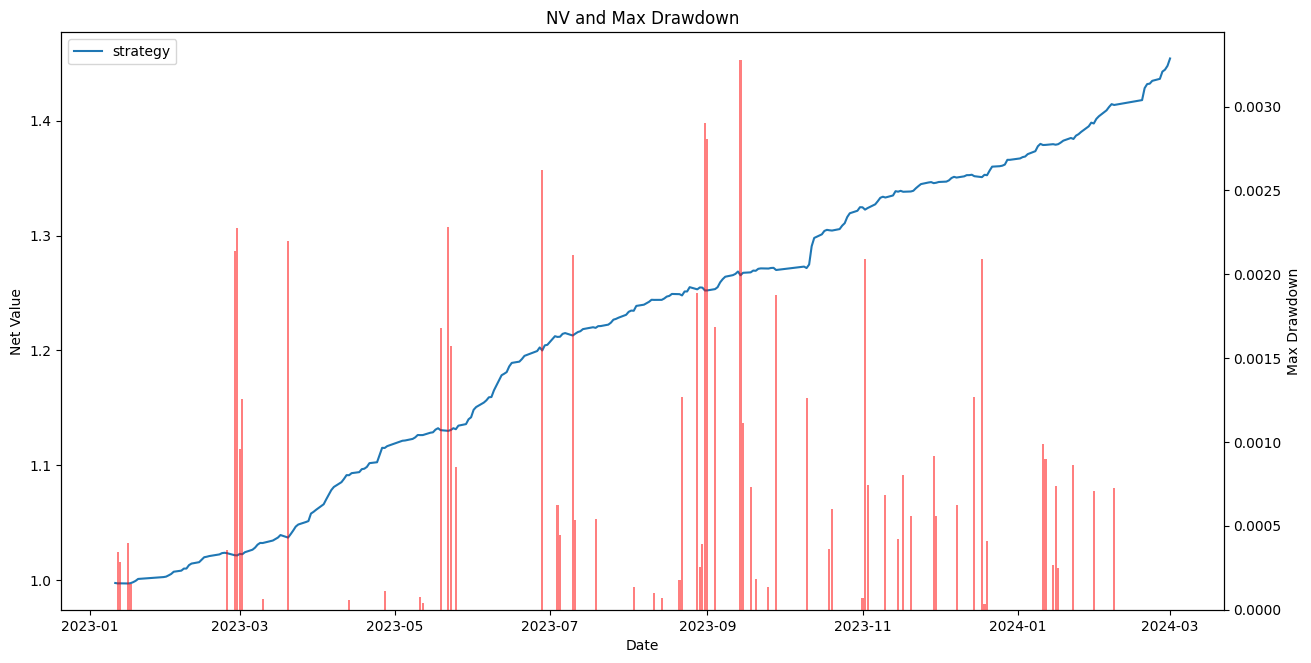

年化收益      0.342249
年化波动      0.028737
夏普比率     11.909575
平均回撤      0.000226
最大回撤      0.003279
回撤日期    2023-09-14
dtype: object

In [24]:
#中金券池结果
# ret_dict = ans_dict['ret_dict']
# ret_dict2 = 
ret1 = pd.Series(ret_dict)
# ret1 = ret1[datetime.strptime('20230701','%Y%m%d').date():]
# ret2 = pd.Series(ret_dict2)
# ret1 = pd.concat([ret2,ret1]).sort_index()
analyse(ret1,trade_df_dict,para['im'],plotting=True)

<Axes: >

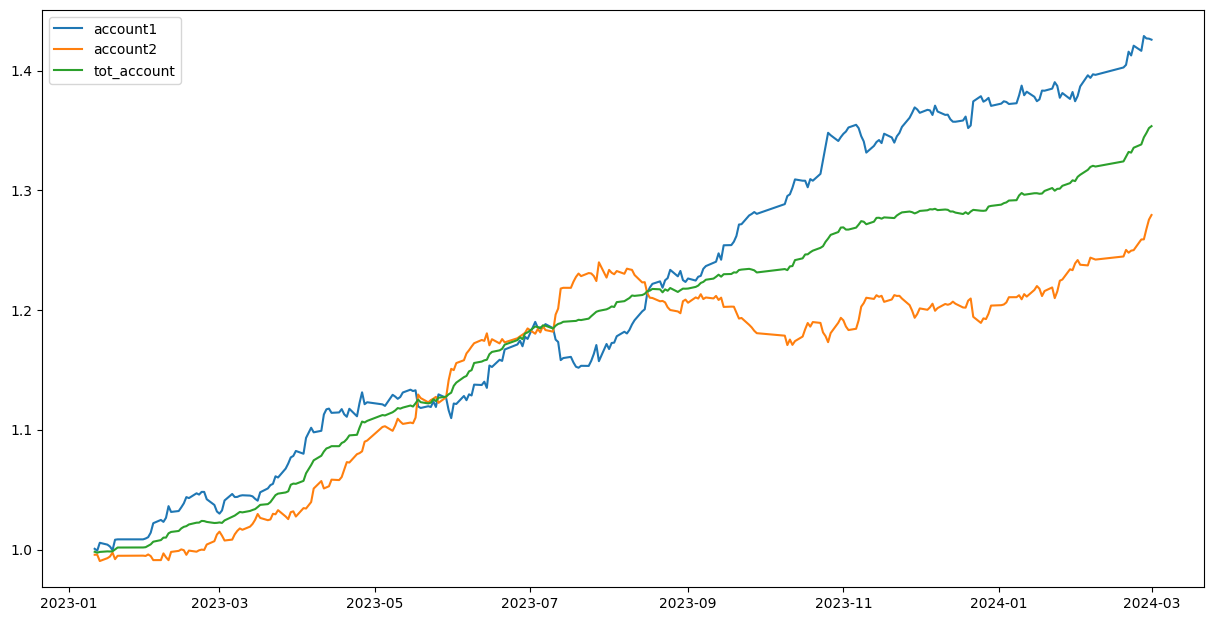

In [14]:
ret_s1 = pd.Series(ret_dict_s1) / 50000000
ret_s2 = pd.Series(ret_dict_s2) / 50000000
ret_total = (ret_s1 + ret_s2) / 2
ret_total = pd.DataFrame({'account1':ret_s1,'account2':ret_s2,'tot_account':ret_total})
(ret_total+1).cumprod().plot(figsize=(15, 7.5))

------绝对收益------
年化收益:0.28515272788113366
年化波动:0.025245818107417797
夏普比率:11.295048022125664
平均回撤:0.0004034214757359651
最大回撤:0.00456134489534854
回撤日期:2023-12-26


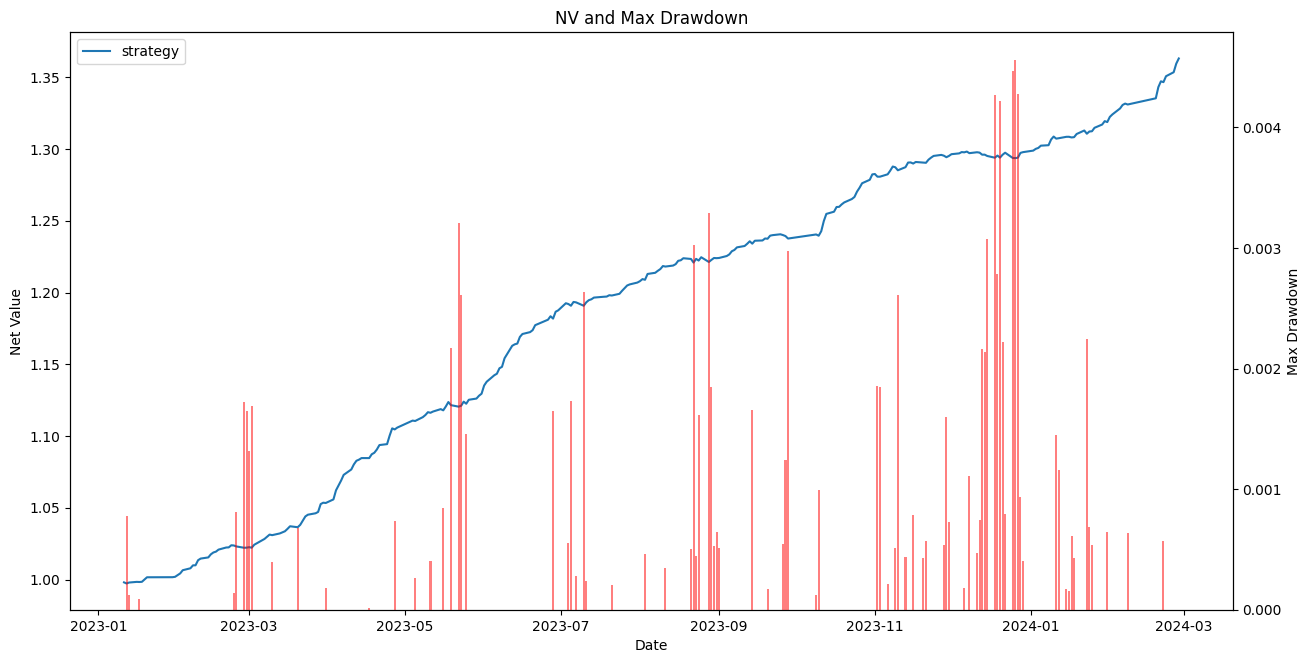

年化收益      0.285153
年化波动      0.025246
夏普比率     11.295048
平均回撤      0.000403
最大回撤      0.004561
回撤日期    2023-12-26
dtype: object

In [3]:
#海通券池结果
# ret_dict = ans_dict['ret_dict']
# ret_dict2 = 
ret1 = pd.Series(ret_dict)
# ret2 = pd.Series(ret_dict2)
# ret1 = pd.concat([ret2,ret1]).sort_index()
analyse(ret1,trade_df_dict,para['im'],plotting=True)

In [68]:
import torch

# 假设 Globalconfig.base_data_shape 已经定义
base_data_shape = (2820*1260, 6500)  # 示例形状，替换为实际形状

# 使用 torch.full 创建一个全 NaN 的张量
tensor = torch.full(base_data_shape, 0, device='cpu')
tensor

<Axes: >

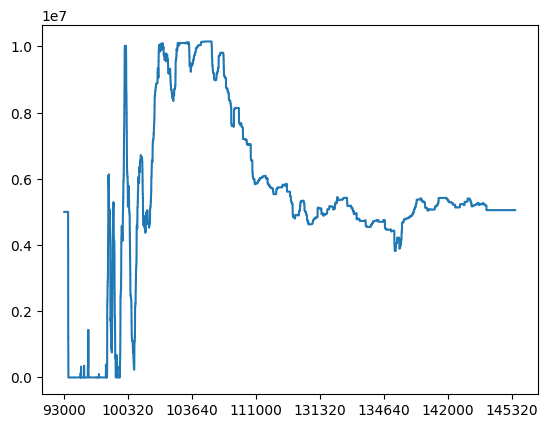

In [25]:
test = tot_account_dict[list(tot_account_dict.keys())[105]]
test.index = test.index.astype('category')
test['cash'].plot()

In [9]:
test

,tot_account,cash,buy,sell
93000,5.000000e+06,5.000000e+06,0.0,0.0
93001,5.000000e+06,5.000000e+06,0.0,0.0
93002,5.000000e+06,5.000000e+06,0.0,0.0
93003,5.000000e+06,5.000000e+06,0.0,0.0
93004,5.000000e+06,5.000000e+06,0.0,0.0
...,...,...,...,...
145455,5.762160e+06,5.762160e+06,0.0,0.0
145456,5.762160e+06,5.762160e+06,0.0,0.0
145457,5.762160e+06,5.762160e+06,0.0,0.0
145458,5.762160e+06,5.762160e+06,0.0,0.0


In [6]:
with open(r'/home/datamake8/高频策略回测/T0_zz10000.020655.pkl','rb') as f:
    ans_dict = pkl.load(f)
trade_df_dict = ans_dict['trade_df_dict']
tot_account_dict = ans_dict['tot_account_dict']
para = ans_dict['params']
ret_dict = ans_dict['ret_dict']
para

{'im': 500000000,
 'min': 0.2,
 'rank1': 0.01,
 'rank2': 0.005,
 'back': 0.1,
 'amp_ratio': 0.5}

------绝对收益------
年化收益:0.0327431932644094
年化波动:0.007813100794830956
夏普比率:4.190806457542678
平均回撤:0.0011965123919046132
最大回撤:0.0031982893136163204
回撤日期:2023-02-13
平均胜率:0.5538830833131454
平均底仓使用率:0.34919411966525415


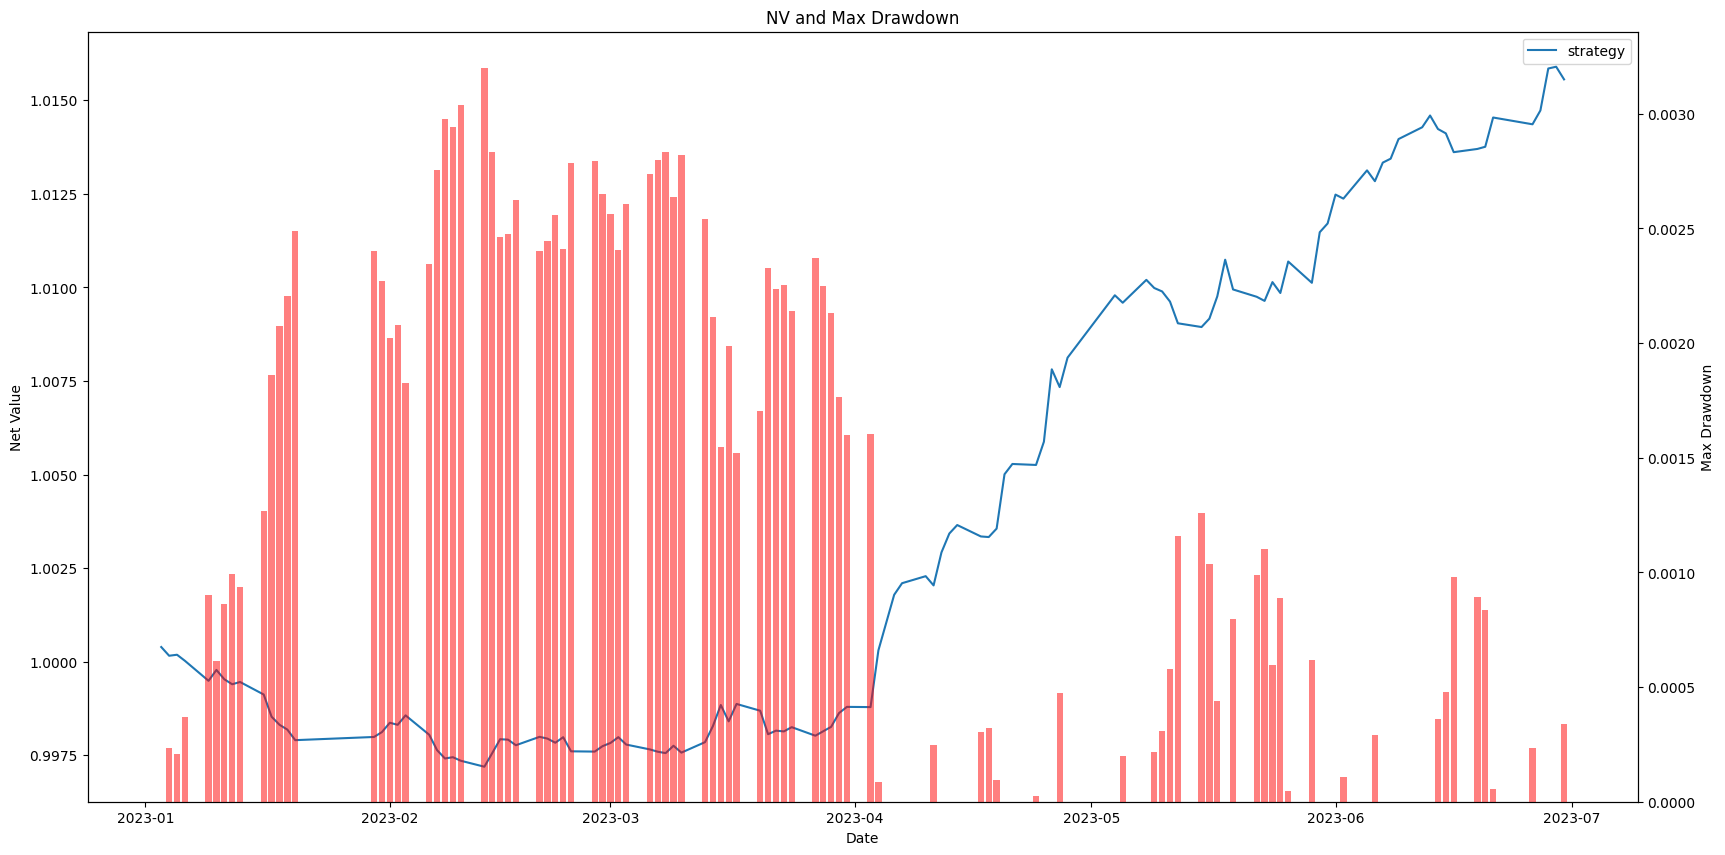

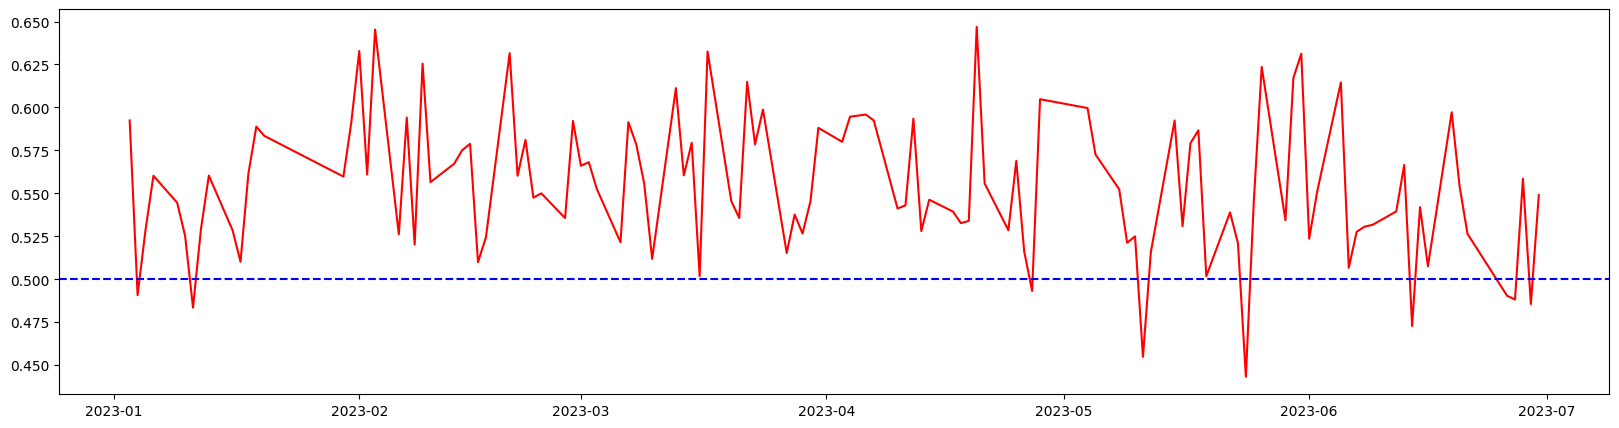

年化收益      0.032743
年化波动      0.007813
夏普比率      4.190806
平均回撤      0.001197
最大回撤      0.003198
回撤日期    2023-02-13
dtype: object

In [7]:
ret_dict = ans_dict['ret_dict']
ret2 = pd.Series(ret_dict)
analyse(ret1,trade_df_dict,para['im'],plotting=True)

<Axes: >

/home/datamake8/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  func(*args, **kwargs)
/home/datamake8/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from current font.
  func(*args, **kwargs)
/home/datamake8/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from current font.
  func(*args, **kwargs)
/home/datamake8/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from current font.
  func(*args, **kwargs)
/home/datamake8/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  func(*args, **kwargs)
/home/datamake8/.local/lib/python3.8/site-packages/IPython/core/p

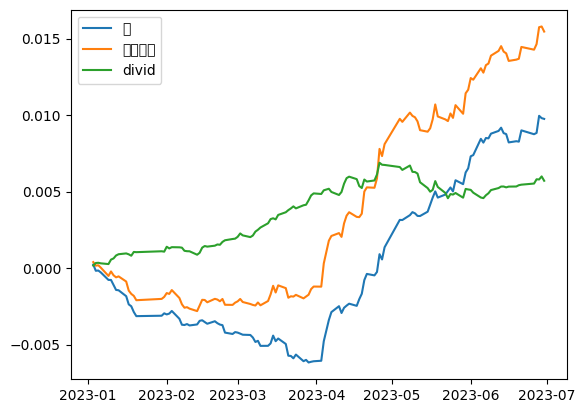

In [11]:
ret_df = pd.DataFrame({'原':ret2,'新加因子':ret1})
ret_df['divid'] = ret_df['新加因子'] - ret_df['原']
ret_df.cumsum().plot()